In [4]:
#one level up into project folder
import os
#os.chdir("..")

#print("Current working directory:", os.getcwd())

In [31]:
# import required libraries
import os
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import dagshub
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from visioninfantnet.utils.ml_utils.metric.classification_metric import get_classification_score
# MLflow to DagsHub

import dagshub
dagshub.init(repo_owner='arunps12', repo_name='VisionInfantNet', mlflow=True)

import mlflow
with mlflow.start_run():
  mlflow.log_param('parameter name', 'value')
  mlflow.log_metric('metric name', 1)


Initialized MLflow to track repo "arunps12/VisionInfantNet"

Repository arunps12/VisionInfantNet initialized!

🏃 View run industrious-ray-331 at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/10ad646f056540b4b67a790626a1938c
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0


In [11]:
import os

def get_latest_artifact(root_dir="artifacts"):
    """
    Returns full path to the most recent timestamped artifact folder.
    Example folder names: '12_06_2025_14_47_14'
    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"{root_dir} does not exist.")

    # list subdirectories
    subdirs = [
        os.path.join(root_dir, d)
        for d in os.listdir(root_dir)
        if os.path.isdir(os.path.join(root_dir, d))
    ]

    if not subdirs:
        raise FileNotFoundError(f"No artifact folders found in {root_dir}.")

    # sort by creation time
    latest = max(subdirs, key=os.path.getmtime)
    return latest

latest_artifact_dir = get_latest_artifact()

print("Latest artifact directory:")
print(latest_artifact_dir)


Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [12]:
latest_artifact_dir = get_latest_artifact()
print("Latest artifact directory:")
print(latest_artifact_dir)

Latest artifact directory:
artifacts/12_06_2025_14_47_14


In [18]:
feature_root = os.path.join(latest_artifact_dir, "data_transformation", "features")

paths = {
    "egemaps_train": f"{feature_root}/train_compare_features.npy",
    "egemaps_valid": f"{feature_root}/valid_compare_features.npy",

    "boaw_train": f"{feature_root}/train_boaw_features.npy",
    "boaw_valid": f"{feature_root}/valid_boaw_features.npy",

    "fv_train": f"{feature_root}/train_fv_features.npy",
    "fv_valid": f"{feature_root}/valid_fv_features.npy",

    "panns_train": f"{feature_root}/train_panns_features.npy",
    "panns_valid": f"{feature_root}/valid_panns_features.npy",

    "resnet_train": f"{feature_root}/train_image_embeddings.npy",
    "resnet_valid": f"{feature_root}/valid_image_embeddings.npy",

    "labels_train": f"{feature_root}/train_labels.npy",
    "labels_valid": f"{feature_root}/valid_labels.npy",
}

paths


{'egemaps_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_compare_features.npy',
 'egemaps_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_compare_features.npy',
 'boaw_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_boaw_features.npy',
 'boaw_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_boaw_features.npy',
 'fv_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_fv_features.npy',
 'fv_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_fv_features.npy',
 'panns_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_panns_features.npy',
 'panns_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/valid_panns_features.npy',
 'resnet_train': 'artifacts/12_06_2025_14_47_14/data_transformation/features/train_image_embeddings.npy',
 'resnet_valid': 'artifacts/12_06_2025_14_47_14/data_transformation/features/v

In [19]:
# --- Low-Level Audio Features ---
X_train_egemaps = np.load(paths["egemaps_train"])
X_valid_egemaps = np.load(paths["egemaps_valid"])

X_train_boaw = np.load(paths["boaw_train"])
X_valid_boaw = np.load(paths["boaw_valid"])

X_train_fv = np.load(paths["fv_train"])
X_valid_fv = np.load(paths["fv_valid"])

# --- Deep Audio Embeddings ---
X_train_panns = np.load(paths["panns_train"])
X_valid_panns = np.load(paths["panns_valid"])

# --- Image Embeddings ---
X_train_resnet = np.load(paths["resnet_train"])
X_valid_resnet = np.load(paths["resnet_valid"])

# --- Labels ---
y_train = np.load(paths["labels_train"])
y_valid = np.load(paths["labels_valid"])

print("Loaded all feature tensors successfully!")


Loaded all feature tensors successfully!


In [23]:
import numpy as np

print("eGeMAPS train NaN:", np.isnan(X_train_egemaps).any())
print("BoAW train NaN:", np.isnan(X_train_boaw).any())
print("FV train NaN:", np.isnan(X_train_fv).any())
print("PANNs train NaN:", np.isnan(X_train_panns).any())
print("ResNet train NaN:", np.isnan(X_train_resnet).any())

eGeMAPS train NaN: True
BoAW train NaN: False
FV train NaN: False
PANNs train NaN: False
ResNet train NaN: False


In [34]:
def plot_confusion_matrix_local(cm, class_names, title):
    """confusion matrix (heatmap)"""
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def evaluate_feature_type(name, X_train, y_train, X_valid, y_valid):
    """
    Train SVM → Impute NaNs → Scale → Evaluate → Log to MLflow
    """
    with mlflow.start_run(run_name=f"Feature-{name}"):

        model = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
            ("svm", SVC(kernel="rbf", probability=True))
        ])

        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)

        acc = accuracy_score(y_valid, y_pred)
        metrics = get_classification_score(
            y_true=y_valid,
            y_pred=y_pred,
            average="weighted"
        )

        print(f"\n===== {name} Feature Evaluation =====")
        print("Accuracy:", acc)
        print("Weighted F1:", metrics.f1_score)
        print("Weighted Precision:", metrics.precision_score)
        print("Weighted Recall:", metrics.recall_score)
        print("UAR (macro recall):", metrics.uar)

        class_names = sorted(np.unique(y_train))
        cm = confusion_matrix(y_valid, y_pred)
        plot_confusion_matrix_local(cm, class_names, f"{name} Confusion Matrix")

        # save confusion matrix as CSV + log to MLflow
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_path = f"cm_{name}.csv"
        cm_df.to_csv(cm_path)
        mlflow.log_artifact(cm_path)
        
        # MLflow logging
        mlflow.log_param("feature_type", name)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", metrics.f1_score)
        mlflow.log_metric("precision", metrics.precision_score)
        mlflow.log_metric("recall", metrics.recall_score)
        mlflow.log_metric("uar", metrics.uar)
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/svm_{name}.joblib"
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path, artifact_path="models")
        #mlflow.sklearn.log_model(model, f"svm_{name}")

        return acc, metrics



===== eGeMAPS Feature Evaluation =====
Accuracy: 0.6477653631284916
Weighted F1: 0.6077707465324556
Weighted Precision: 0.6039905773597332
Weighted Recall: 0.6477653631284916
UAR (macro recall): 0.32692110594616075


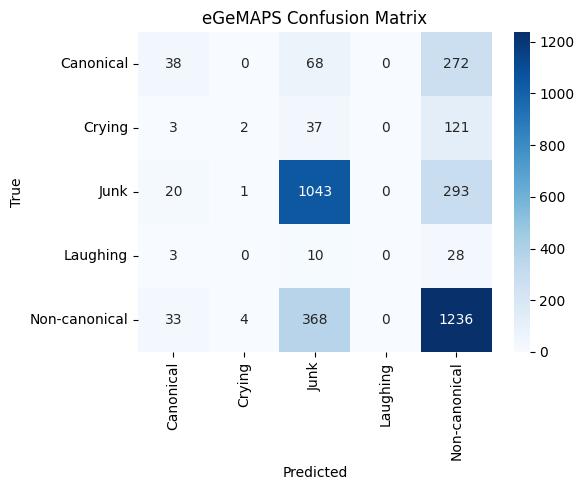

🏃 View run Feature-eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/344dcb073de046059d14fee1be6c0426
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

===== BoAW Feature Evaluation =====
Accuracy: 0.5849162011173185
Weighted F1: 0.5419453726805323
Weighted Precision: 0.5375319610731994
Weighted Recall: 0.5849162011173185
UAR (macro recall): 0.2971222370354699


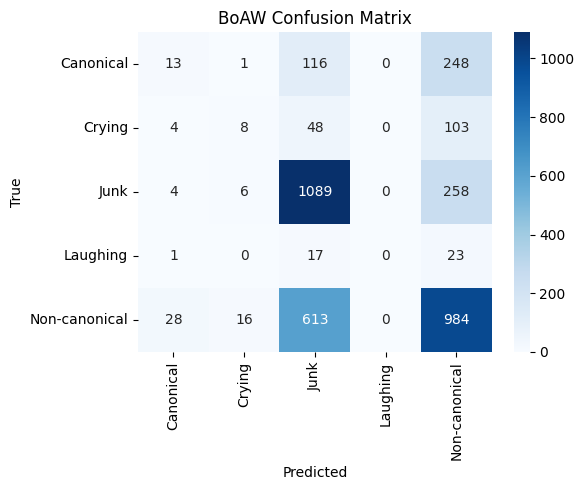

🏃 View run Feature-BoAW at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/6a8078f3369f45c49689a6f1b43368dc
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

===== FisherVector Feature Evaluation =====
Accuracy: 0.6067039106145251
Weighted F1: 0.5643126168693229
Weighted Precision: 0.5590821290525325
Weighted Recall: 0.6067039106145251
UAR (macro recall): 0.31318669746171873


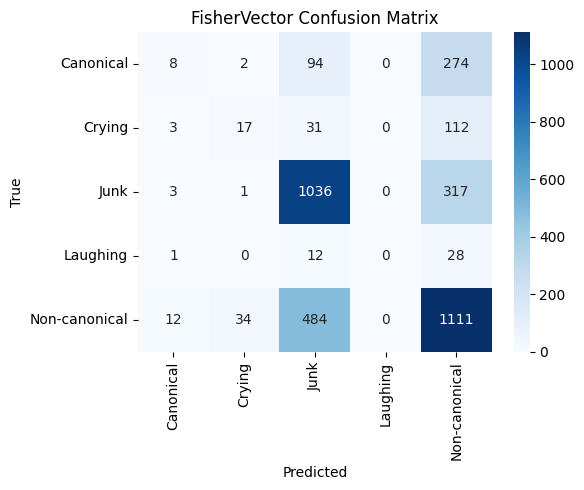

🏃 View run Feature-FisherVector at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/c201cf5a8218457fab165af3d56c57c6
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

===== PANNs Feature Evaluation =====
Accuracy: 0.4583798882681564
Weighted F1: 0.28814456872171795
Weighted Precision: 0.21011212196872756
Weighted Recall: 0.4583798882681564
UAR (macro recall): 0.2


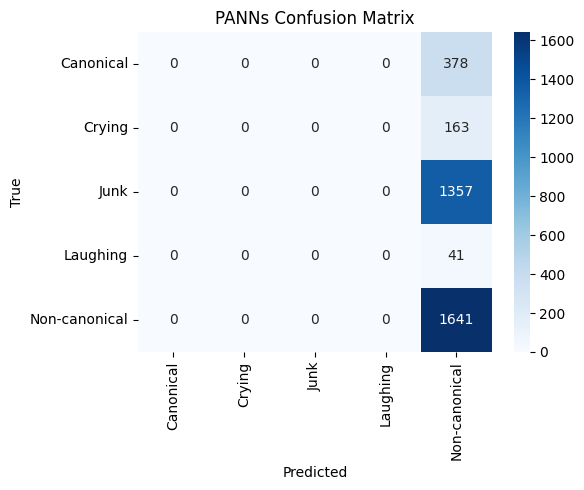

🏃 View run Feature-PANNs at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/c3f96bbb8ac84f08bcb08ebc4466a219
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

===== ResNet50 Feature Evaluation =====
Accuracy: 0.6304469273743016
Weighted F1: 0.5808435014298469
Weighted Precision: 0.575353126551586
Weighted Recall: 0.6304469273743016
UAR (macro recall): 0.3069228992755052


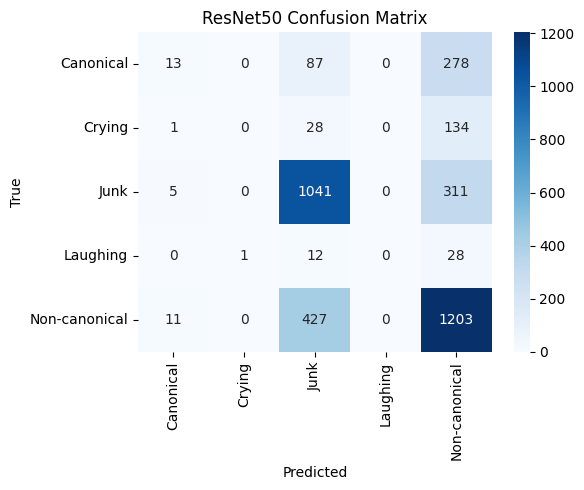

🏃 View run Feature-ResNet50 at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/aa95d14618274ff89122a786988c6ae8
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

=== FINAL FEATURE SELECTION RESULTS ===
eGeMAPS: 0.6478
BoAW: 0.5849
FisherVector: 0.6067
PANNs: 0.4584
ResNet50: 0.6304


In [35]:
results = {}

acc, _ = evaluate_feature_type(
    "eGeMAPS", X_train_egemaps, y_train, X_valid_egemaps, y_valid
)
results["eGeMAPS"] = acc

acc, _ = evaluate_feature_type(
    "BoAW", X_train_boaw, y_train, X_valid_boaw, y_valid
)
results["BoAW"] = acc

acc, _ = evaluate_feature_type(
    "FisherVector", X_train_fv, y_train, X_valid_fv, y_valid
)
results["FisherVector"] = acc

acc, _ = evaluate_feature_type(
    "PANNs", X_train_panns, y_train, X_valid_panns, y_valid
)
results["PANNs"] = acc

acc, _ = evaluate_feature_type(
    "ResNet50", X_train_resnet, y_train, X_valid_resnet, y_valid
)
results["ResNet50"] = acc

print("\n=== FINAL FEATURE SELECTION RESULTS ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Label Encoding:
Canonical → 0
Crying → 1
Junk → 2
Laughing → 3
Non-canonical → 4

[INFO] Best feature type selected: eGeMAPS

[INFO] Imputing NaNs (median) for BEST feature: eGeMAPS

>>> Training SVM on eGeMAPS features
Accuracy: 0.6478
Weighted F1: 0.6077707465324556
Weighted Precision: 0.6039905773597332
Weighted Recall: 0.6477653631284916
UAR (macro recall): 0.32692110594616075


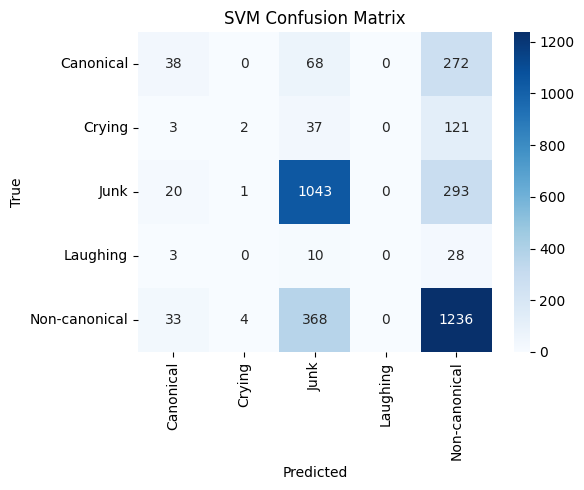

🏃 View run SVM_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/841c2f8de2f84730ad008cf6436ad70c
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

>>> Training RandomForest on eGeMAPS features
Accuracy: 0.6595
Weighted F1: 0.6227977107264969
Weighted Precision: 0.6243935056190948
Weighted Recall: 0.6594972067039107
UAR (macro recall): 0.3396817044975576


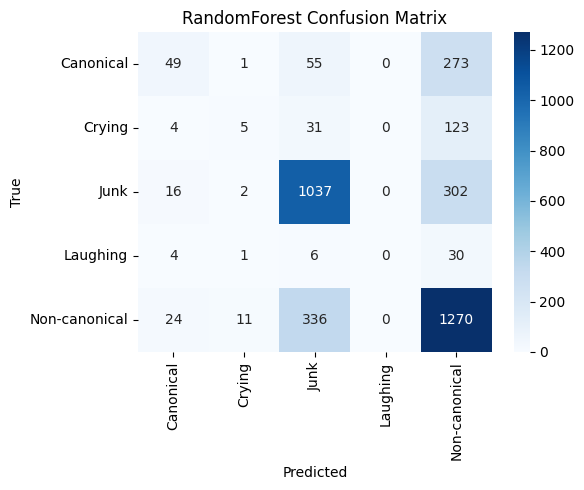

🏃 View run RandomForest_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/5a4dc69f9c2640c89f740a019761e82b
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

>>> Training GradientBoosting on eGeMAPS features
Accuracy: 0.6341
Weighted F1: 0.6209159172299432
Weighted Precision: 0.6138550243350186
Weighted Recall: 0.6340782122905028
UAR (macro recall): 0.3733660471301056


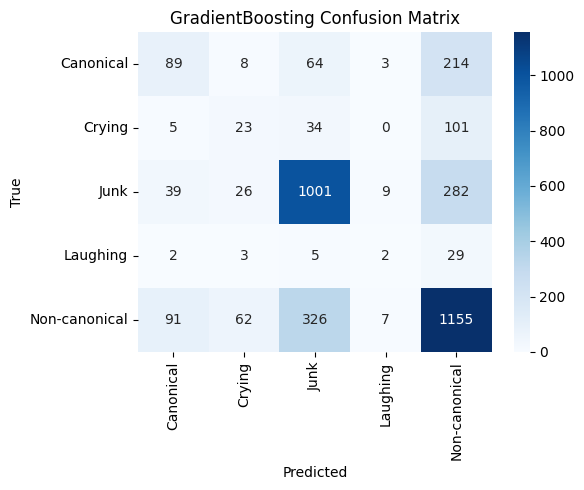

🏃 View run GradientBoosting_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/c3d91c2b2bd740cfb643f3d7ebbc79c8
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

>>> Training AdaBoost on eGeMAPS features
Accuracy: 0.6134
Weighted F1: 0.5880733769717699
Weighted Precision: 0.5732881234320223
Weighted Recall: 0.6134078212290502
UAR (macro recall): 0.3308329000911545


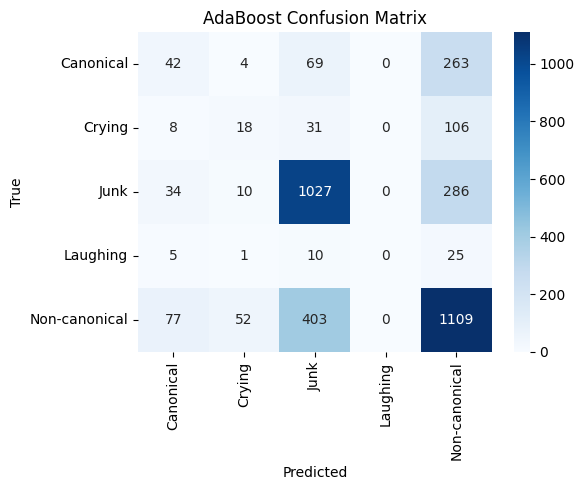

🏃 View run AdaBoost_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/e5e4302fd6a44e2d9e98432ccfe88d66
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

>>> Training DecisionTree on eGeMAPS features
Accuracy: 0.5095
Weighted F1: 0.5168135449929716
Weighted Precision: 0.5297906337235235
Weighted Recall: 0.5094972067039106
UAR (macro recall): 0.3234401545442896


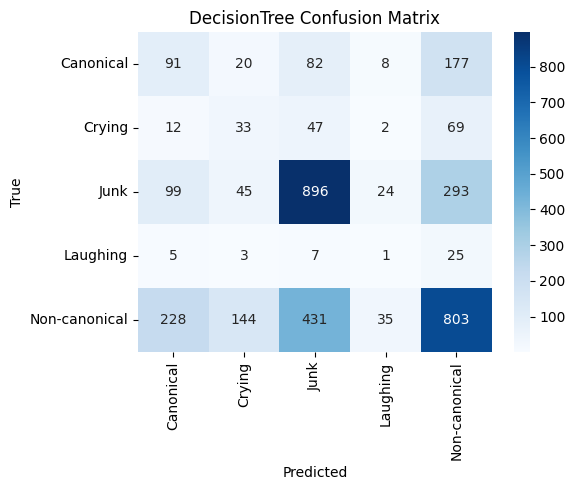

🏃 View run DecisionTree_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/93a02c72b5d644cd8a21df0cc05425e3
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

>>> Training XGBoost on eGeMAPS features
Accuracy: 0.6478
Weighted F1: 0.6319018079617431
Weighted Precision: 0.6228049823278919
Weighted Recall: 0.6477653631284916
UAR (macro recall): 0.3805748536779624


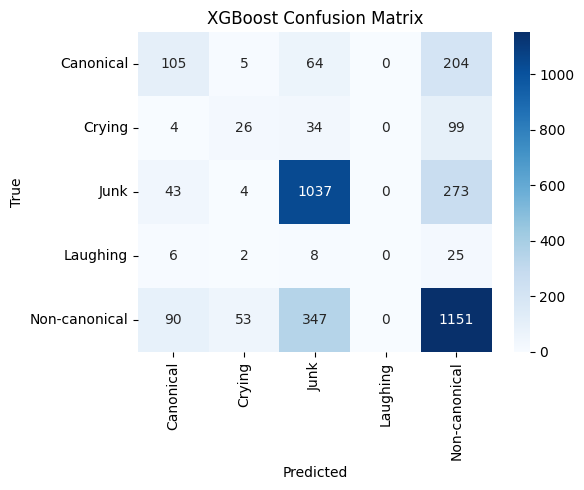

🏃 View run XGBoost_on_eGeMAPS at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0/runs/f241ffc3ef7c4bd486a316ccc4483115
🧪 View experiment at: https://dagshub.com/arunps12/VisionInfantNet.mlflow/#/experiments/0

=== FINAL MODEL COMPARISON ON BEST FEATURE ===
SVM: 0.6478
RandomForest: 0.6595
GradientBoosting: 0.6341
AdaBoost: 0.6134
DecisionTree: 0.5095
XGBoost: 0.6478


In [39]:
# ============================
# Cell 6: Compare ML models using BEST feature (with XGBoost, Imputation, Confusion Matrix, MLflow)
# ============================

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib
import os
import numpy as np


label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_valid_enc = label_encoder.transform(y_valid)

print("Label Encoding:")
for original, encoded in zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)):
    print(f"{original} → {encoded}")

feature_map = {
    "eGeMAPS": (X_train_egemaps, X_valid_egemaps),
    "BoAW": (X_train_boaw, X_valid_boaw),
    "FisherVector": (X_train_fv, X_valid_fv),
    "PANNs": (X_train_panns, X_valid_panns),
    "ResNet50": (X_train_resnet, X_valid_resnet),
}
best_feature = max(results, key=results.get)
print(f"\n[INFO] Best feature type selected: {best_feature}")
X_train_best, X_valid_best = feature_map[best_feature]


print(f"\n[INFO] Imputing NaNs (median) for BEST feature: {best_feature}")
imputer = SimpleImputer(strategy="median")
X_train_best_imp = imputer.fit_transform(X_train_best)
X_valid_best_imp = imputer.transform(X_valid_best)

# -----------------------------
# Define ML models
# -----------------------------
models = {
    "SVM": Pipeline([
        
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", probability=True))
    ]),

    "RandomForest": RandomForestClassifier(n_estimators=200),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "DecisionTree": DecisionTreeClassifier(),

    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        tree_method="auto"
    ),
}

model_results = {}

# -----------------------------
# Loop through models
# -----------------------------
for name, model in models.items():

    print(f"\n>>> Training {name} on {best_feature} features")

    with mlflow.start_run(run_name=f"{name}_on_{best_feature}"):

        # Train
        model.fit(X_train_best_imp, y_train_enc)

        # Predict
        y_pred_enc = model.predict(X_valid_best_imp)
        y_pred = label_encoder.inverse_transform(y_pred_enc)

        # Evaluate
        acc = accuracy_score(y_valid, y_pred)
        metrics = get_classification_score(y_valid, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print("Weighted F1:", metrics.f1_score)
        print("Weighted Precision:", metrics.precision_score)
        print("Weighted Recall:", metrics.recall_score)
        print("UAR (macro recall):", metrics.uar)

        # ----- Confusion Matrix -----
        class_names = list(label_encoder.classes_)
        cm = confusion_matrix(y_valid, y_pred)
        plot_confusion_matrix_local(cm, class_names, f"{name} Confusion Matrix")

        # Save confusion matrix CSV
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
        cm_path = f"cm_{name}_{best_feature}.csv"
        cm_df.to_csv(cm_path)
        mlflow.log_artifact(cm_path)

        # ----- Log MLflow -----
        mlflow.log_param("model", name)
        mlflow.log_param("feature_type", best_feature)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", metrics.f1_score)
        mlflow.log_metric("precision", metrics.precision_score)
        mlflow.log_metric("recall", metrics.recall_score)
        mlflow.log_metric("uar", metrics.uar)

        # ----- Save model -----
        os.makedirs("saved_models", exist_ok=True)
        model_path = f"saved_models/{name}_{best_feature}.joblib"
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path, artifact_path="models")

        model_results[name] = acc


# -----------------------------
# Final Comparison
# -----------------------------
print("\n=== FINAL MODEL COMPARISON ON BEST FEATURE ===")
for k, v in model_results.items():
    print(f"{k}: {v:.4f}")
